In [1]:
# Install required dependencies and import required libraries
!pip install scikit-image
!pip install torch torchvision
!pip install pandas
!pip install imutils
import re
import numpy as np
import skimage as sk
import skimage.io as skio
from skimage.color import rgb2gray
import skimage.transform as skt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
!pip3 install opencv-python --upgrade --force-reinstall
import cv2
from skimage.transform import warp
import matplotlib.pyplot as plt
from skimage import data
from skimage.transform import rotate
from torch.utils.data import Dataset, DataLoader
import math
import scipy as scp
from scipy.spatial import Delaunay
import skimage.draw as draw
import imageio
from skimage.transform import resize
import os
from PIL import Image
import random
from __future__ import print_function, division
import os
import torch
from scipy import ndimage
import imgaug as ia
from imgaug.augmentables import Keypoint, KeypointsOnImage
import imgaug.augmenters as iaa
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
# Ignore warnings
import warnings
from skimage.transform import SimilarityTransform
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

You should consider upgrading via the 'C:\Users\abely\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\abely\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\abely\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'C:\Users\abely\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\abely\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~-4py\\.libs\\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'C:\Users\abely\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


  Using cached opencv_python-4.5.4.60-cp39-cp39-win_amd64.whl (35.1 MB)
  Using cached numpy-1.21.4-cp39-cp39-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4


In [2]:
# Function that returns the image along with the nosepoint/facepoints, depending
# on the `just_nose` variable.
def get_info(i,j,shape,just_nose=True):
    gender = 'm' # gender
    root_dir = './imm_face_db/'

    # load all facial keypoints/landmarks
    try:
        file = open(root_dir + '{:02d}-{:d}{}.asf'.format(i,j,gender))
    except:
        gender = "f"
        file = open(root_dir + '{:02d}-{:d}{}.asf'.format(i,j,gender))

    points = file.readlines()[16:74]
    landmark = []

    for point in points:
        x,y = point.split('\t')[2:4]
        landmark.append([float(x), float(y)])

    if just_nose:
        # if just_nose, then only return nosepoint
        pts = np.array(landmark).astype('float32')[-6]
    else:
        # otherwise, return all facepoints
        pts = np.array(landmark).astype('float32')

    # image filename declaration
    zero = ""
    if i < 10:
        zero = "0"
    imgstr = "imm_face_db/"+zero+str(i)+"-"+str(j)+gender+".jpg"

    # Adjust image to be a float within [-0.5,0.5], anti-aliasing for clarity
    retimg = rgb2gray(np.mean(skt.resize(((skio.imread(imgstr).astype(np.float32))/255-0.5),shape,anti_aliasing=True),axis=2))

    # return image and points
    return retimg,pts

# Way to retrieve all points
x = []
y = []
# Iterate through all individuals
for i in range(1,41):
    # Iterate through all angles of images
    for j in range(1,7):
        # get nosepoint and image, update the x and y variables
        img,nose = get_info(i,j,(60,80))
        x.append(img)
        y.append(nose)

# Declare as numpy array for mathematical modification
x = np.array(x)
y = np.array(y)
# Split into train and validation dataset
x_train = x[:192]
x_valid = x[192:241]
y_train = y[:192]
y_valid = y[192:241]

In [3]:
class NoseKeypointDataset(Dataset):
    """Nose Keypoint dataset."""

    def __init__(self,transform, x,y,bboxes=None,large_dataset=False,test=False):
        """
        Args:
            x: Input image.
            y: Input nosepoint/facepoints.
            bboxes: Used for the larger dataset in Part 3.
            large_dataset: Boolean indicator for task 3.
            test: Boolean indicator for the test set for task 3.
            transform: Image transformation details.
        """
        self.x = x
        self.y = y
        self.transform = transform
        self.bboxes = bboxes
        self.large_dataset = large_dataset
        self.test = test
        # Reshape bboxes if need be
        if self.bboxes is not None:
            self.bboxes[:,0] = (self.bboxes[:,0]-self.bboxes[:,2]*0.1)
            self.bboxes[:,1] = (self.bboxes[:,1]-self.bboxes[:,3]*0.1)
            self.bboxes[:,2] = (self.bboxes[:,2]*1.2)
            self.bboxes[:,3] = (self.bboxes[:,3]*1.2)
            if self.y is not None:
                # Reshape facepoints if need be (to 224x224 resolution)
                self.y[:,:,0] = (self.y[:,:,0]-self.bboxes[:,0].reshape(self.bboxes.shape[0],1))/self.bboxes[:,2].reshape((self.bboxes.shape[0],1))*224
                self.y[:,:,1] = (self.y[:,:,1]-self.bboxes[:,1].reshape(self.bboxes.shape[0],1))/self.bboxes[:,3].reshape((self.bboxes.shape[0],1))*224
        

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.large_dataset:
            img = skio.imread(self.x[idx])
            if len(img.shape) == 2:
                img = np.dstack((img, img, img))
            bbox = self.bboxes[idx]
            img = transforms.functional.crop(torch.from_numpy(img).permute((2, 0, 1)),bbox[1].astype(int),bbox[0].astype(int),bbox[3].astype(int),bbox[2].astype(int)).permute((1, 2, 0))
            img = rgb2gray(np.mean(skt.resize((img/255-0.5),(224,224),anti_aliasing=True),axis=2))
            if self.test:
                sample = {'image': img}
            else:
                sample = {'image': img, 'points': self.y[idx]}
        else:
            if self.transform is not None:
                sample = {'image': self.transform(self.x[idx]), 'points': self.y[idx]}
            else:
                sample = {'image': self.x[idx], 'points': self.y[idx]}
        return sample

# Create training and validation dataloaders
train_dataloader = DataLoader(NoseKeypointDataset(x=x_train,y=y_train,transform=transforms.ToTensor()),batch_size=1,shuffle=True)
validate_dataloader = DataLoader(NoseKeypointDataset(x=x_valid,y=y_valid,transform=transforms.ToTensor()),batch_size=1,shuffle=True)

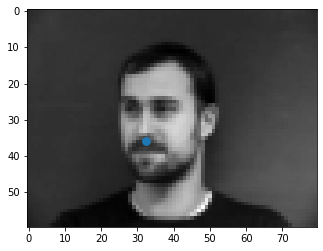

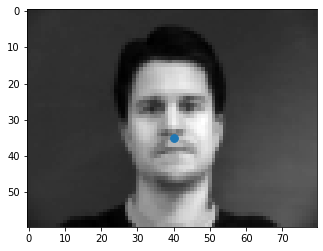

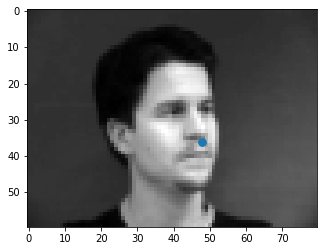

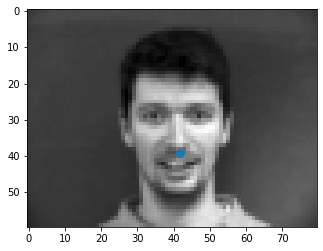

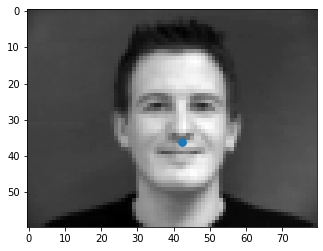

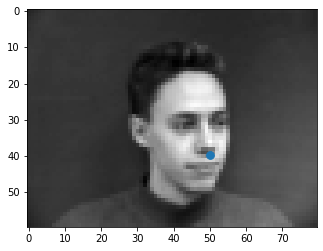

In [4]:
def show_landmarks(image, nose_keypoint, ground_point = None , nose=True, rescale=False):
    """Show image with nose/facial keypoints"""
    plt.imshow(image[0][0],cmap=plt.cm.gray)
    if nose:
        plt.scatter(nose_keypoint[0][0]*(image[0][0].shape[1]),nose_keypoint[0][1]*(image[0][0].shape[0]),s=60)
        if ground_point is not None and rescale == False:
            plt.scatter(ground_point[0][0].item(),ground_point[0][1].item(),s=60)
            plt.legend(["Ground","Predicted"])
        elif ground_point is not None:
            plt.scatter(ground_point[0][0].item()*(image[0][0].shape[1]),ground_point[0][1].item()*(image[0][0].shape[0]),s=60)
            plt.legend(["Ground","Predicted"])
    else:
        if rescale:
            plt.scatter(np.array(nose_keypoint)[0][:,[0]],np.array(nose_keypoint)[0][:,[1]],s=30)
        else:
            if ground_point is None:
                evens = [i for i in range(len(nose_keypoint[0])) if i %2== 0]
                odds = [i for i in range(len(nose_keypoint[0])) if i %2== 1]
                plt.scatter(np.array(nose_keypoint)[0][evens]*(image[0][0].shape[1]),np.array(nose_keypoint)[0][odds]*(image[0][0].shape[0]),s=30)
            else:
                evens = [i for i in range(len(nose_keypoint[0])) if i %2== 0]
                odds = [i for i in range(len(nose_keypoint[0])) if i %2== 1]
                plt.scatter(np.array(nose_keypoint)[0][evens]*(image[0][0].shape[1]),np.array(nose_keypoint)[0][odds]*(image[0][0].shape[0]),s=30)
                plt.scatter(torch.detach(ground_point).numpy()[0][evens]*(image[0][0].shape[1]),torch.detach(ground_point).numpy()[0][odds]*(image[0][0].shape[0]),s=30)
                plt.legend(["Ground","Predicted"])
    plt.show()

# Show example images
for i,c in enumerate(train_dataloader):
    if i % 32 == 0:
        show_landmarks(c['image'],c['points'])

Net(
  (conv1): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1))
  (conv3): Conv2d(20, 20, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=160, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=2, bias=True)
)
TRAINING TIME! *Rocky song plays* 

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


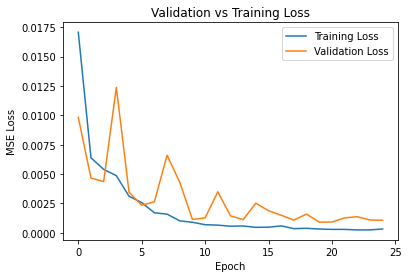

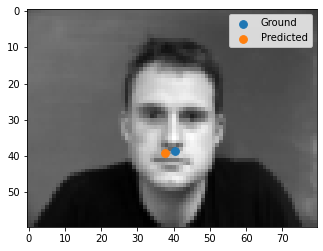

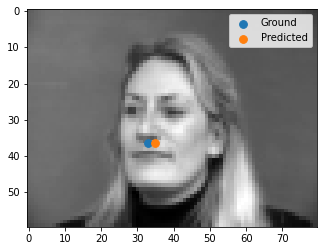

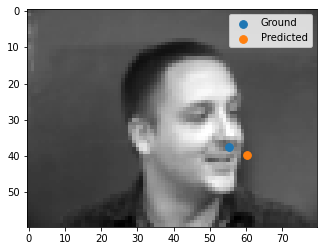

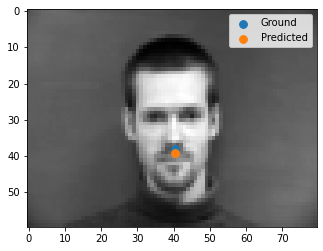

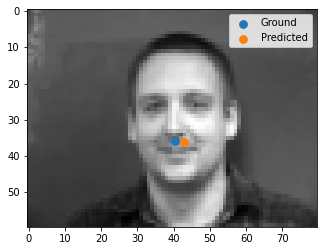

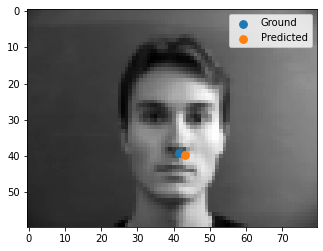

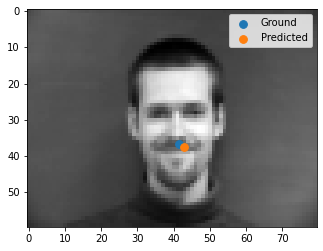

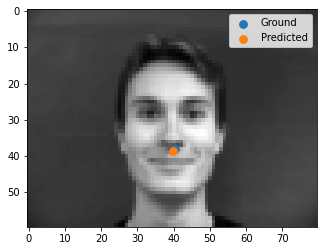

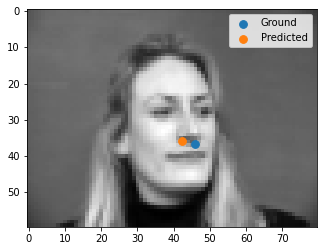

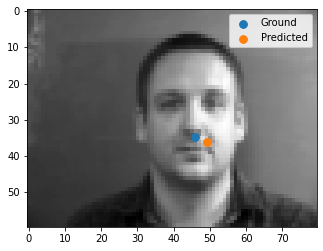

In [5]:
class Net(nn.Module):
    # Initialized Layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 7)
        self.conv2 = nn.Conv2d(20, 20, 7)
        self.conv3 = nn.Conv2d(20, 20, 7)
        self.fc1 = nn.Linear(160, 80)
        self.fc2 = nn.Linear(80, 2)

    # Forward Function, used description from spec.
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # Training function
    def training_montage(self,train_dataloader,validate_dataloader):
      print("TRAINING TIME! *Rocky song plays* \n")
      training_loss = []
      validation_loss = []
      # Use Adam optimizer with Learning rate of 1e-3
      optim = torch.optim.Adam(self.parameters(), lr=1e-3)
      # 25 epochs
      for i in range(25):
        print("Epoch "+str(i+1))
        im_loss = 0
        validate_err = 0
        # Follow loss calculation procedure from tutorial linked in website
        for _,c in enumerate(train_dataloader):
          optim.zero_grad()
          loss = nn.MSELoss()(self(c['image']),c['points'])
          loss.backward()
          optim.step()
          im_loss += loss.item()
        # Get validation error
        for _, c in enumerate(validate_dataloader):
          validate_err += nn.MSELoss()(self(c['image']), c['points']).item()
        # Append errors to loss arrays.
        validation_loss.append(validate_err/len(validate_dataloader))
        training_loss.append(im_loss /len(train_dataloader))
      # Return losses
      return training_loss,validation_loss

net=Net()
print(net)
training_loss, validation_loss = net.training_montage(train_dataloader, validate_dataloader)

# Plot the validation vs training loss plots
plt.title("Validation vs Training Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(["Training Loss","Validation Loss"])

# Display some ground vs predicted nosepoints
for i, c in enumerate(validate_dataloader):
  if i % 5 == 0:
    plt.figure()
    show_landmarks(c['image'],c['points'],ground_point=net(c['image']),nose=True,rescale=True)

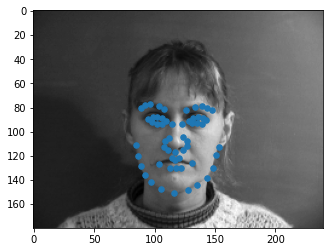

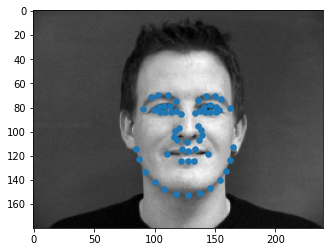

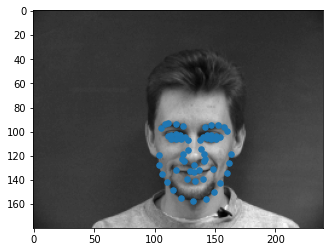

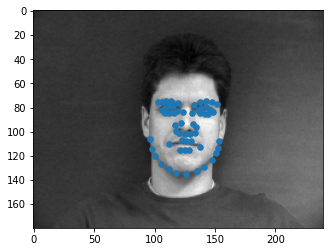

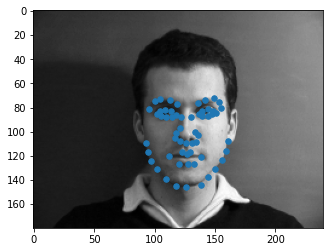

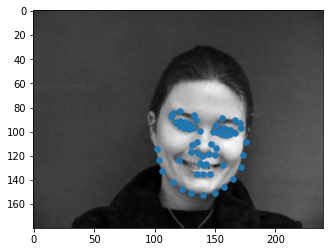

In [6]:
# Way to retrieve all points
x = []
y = []
# Iterate through all individuals
for i in range(1,41):
    # Iterate through all angles of images
    for j in range(1,7):
        # get nosepoint and image, update the x and y variables
        img,nose = get_info(i,j,(180,240),False)
        x.append(img)
        y.append(nose)

# Change arrays to numpy arrays for modification
x = np.array(x)
y = np.array(y).reshape([240,116])

# Split into train and validation dataset
x_train = x[:192]
x_valid = x[192:241]
y_train = y[:192]
y_valid = y[192:241]

# Create training and validation dataloaders
train_dataloader = DataLoader(NoseKeypointDataset(x=x_train, y=y_train,transform=transforms.ToTensor()),batch_size=1,shuffle=True)
validate_dataloader = DataLoader(NoseKeypointDataset(x=x_valid, y=y_valid,transform=transforms.ToTensor()),batch_size=1,shuffle=True)

# Show example images
for i,c in enumerate(train_dataloader):
    if i % 32 == 0:
        show_landmarks(c['image'],c['points'],nose=False)

Net(
  (conv1): Conv2d(1, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv2): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv3): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv4): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (conv5): Conv2d(12, 12, kernel_size=(8, 8), stride=(1, 1))
  (fc1): Linear(in_features=3276, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=116, bias=True)
)
TRAINING TIME! *Rocky song plays* 

Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25


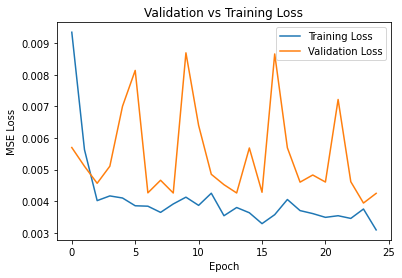

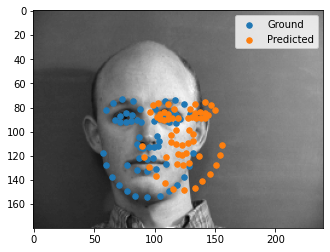

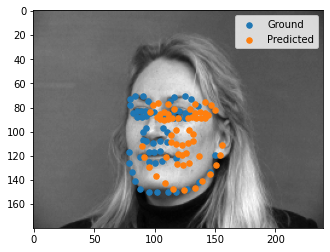

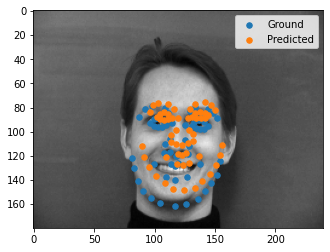

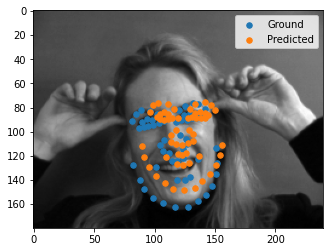

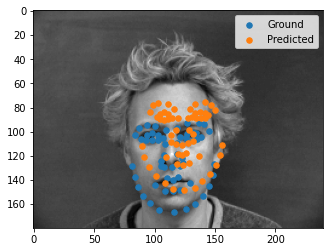

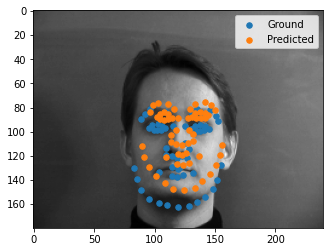

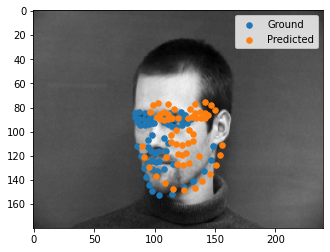

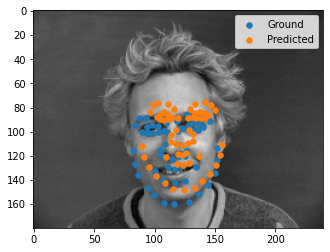

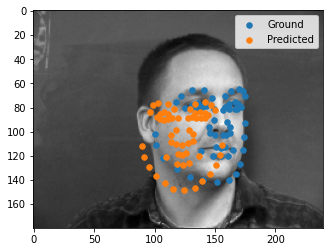

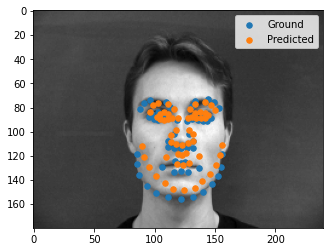

In [7]:
class Net(nn.Module):
    # Initialized Layers
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 12, 8)
        self.conv2 = nn.Conv2d(12, 12, 8)
        self.conv3 = nn.Conv2d(12, 12, 8)
        self.conv4 = nn.Conv2d(12, 12, 8)
        self.conv5 = nn.Conv2d(12, 12, 8)
        self.fc1 = nn.Linear(3276, 500)
        self.fc2 = nn.Linear(500, 116)

    # Forward Function, used description from spec.
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv3(x)
        x = F.relu(x)

        x = self.conv4(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = self.conv5(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)

        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    # Training function
    def training_montage(self,train_dataloader,validate_dataloader):
      print("TRAINING TIME! *Rocky song plays* \n")
      training_loss = []
      validation_loss = []
      # Use Adam optimizer with Learning rate of 1e-3
      optim = torch.optim.Adam(self.parameters(), lr=1e-3)
      # 25 epochs
      for i in range(25):
        print("Epoch "+str(i+1))
        im_loss = 0
        validate_err = 0
        # Follow loss calculation procedure from tutorial linked in website
        for _,c in enumerate(train_dataloader):
          optim.zero_grad()
          loss = nn.MSELoss()(self(c['image']),c['points'])
          loss.backward()
          optim.step()
          im_loss += loss.item()
        # Get validation error
        for _, c in enumerate(validate_dataloader):
          validate_err += nn.MSELoss()(self(c['image']), c['points']).item()
        # Append errors to loss arrays.
        validation_loss.append(validate_err/len(validate_dataloader))
        training_loss.append(im_loss /len(train_dataloader))
      # Return losses
      return training_loss,validation_loss

net=Net()
print(net)
training_loss, validation_loss = net.training_montage(train_dataloader, validate_dataloader)

# Plot the validation vs training loss plots
plt.title("Validation vs Training Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(["Training Loss","Validation Loss"])

# Display ground and predicted facepoints on some images
for i, c in enumerate(validate_dataloader):
  if i % 5 == 0:
    plt.figure()
    show_landmarks(c['image'],c['points'],ground_point=net(c['image']),nose=False,rescale=False)

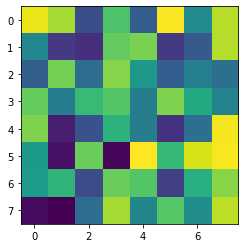

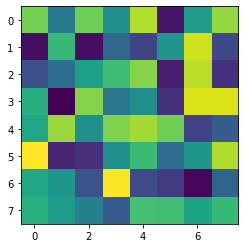

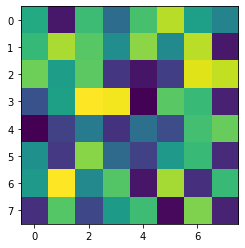

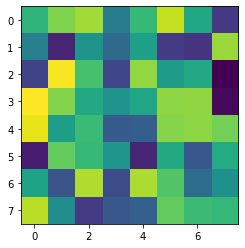

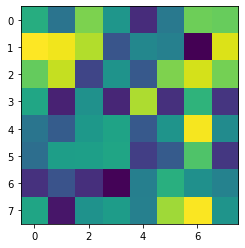

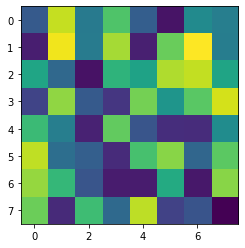

In [8]:
# PLOTS FOR SOME OF THE FEATURES/WEIGHTS

for i in range(len(net.conv1.weight.detach().numpy())):
    if i % 10 == 0:
        plt.figure()
        plt.imshow(net.conv1.weight.detach().numpy()[i][0])
        plt.plot()

for i in range(len(net.conv2.weight.detach().numpy())):
    if i % 10 == 0:
        plt.figure()
        plt.imshow(net.conv2.weight.detach().numpy()[i][0])
        plt.plot()

for i in range(len(net.conv3.weight.detach().numpy())):
    if i % 10 == 0:
        plt.figure()
        plt.imshow(net.conv3.weight.detach().numpy()[i][0])
        plt.plot()

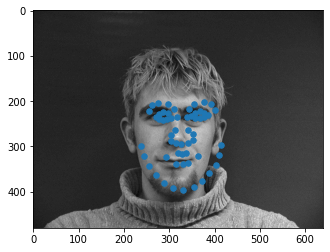

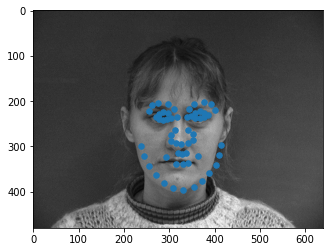

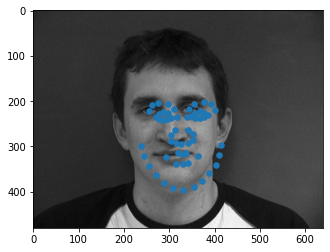

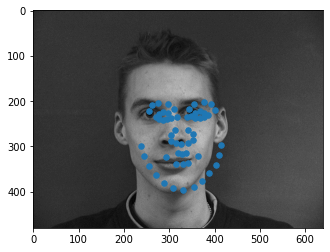

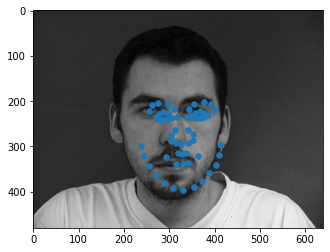

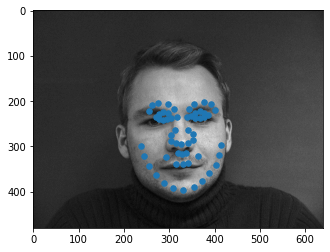

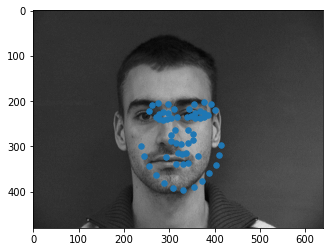

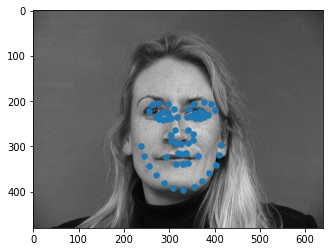

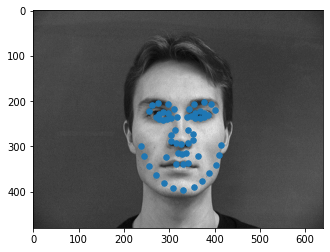

In [9]:
# BELLS AND WHISTLES - Integrating auto-detection to project 3

# Some images that worked well with our keypoint detector
arr = ["imm_face_db/01-1m.jpg","imm_face_db/08-1f.jpg","imm_face_db/11-1m.jpg","imm_face_db/17-1m.jpg","imm_face_db/18-1m.jpg","imm_face_db/19-1m.jpg","imm_face_db/23-1m.jpg","imm_face_db/35-1f.jpg","imm_face_db/38-1m.jpg"]
ptsd = []

# Iterate through all of these images and display them for visual purposes.
for imgstr in arr:
    im1 = skio.imread(imgstr,as_gray=True)
    convert_tensor = transforms.ToTensor()
    im1.resize([180,240])
    kpts = net(torch.reshape(convert_tensor(im1),[1,1,180,240]).float())
    plt.figure()
    plt.imshow(skio.imread(imgstr,as_gray=True),plt.cm.gray)
    evens = [i for i in range(len(kpts[0])) if i % 2 == 0]
    odds = [i for i in range(len(kpts[0])) if i % 2 == 1]
    ptsd.append([kpts[0].detach().numpy()[evens]*640,kpts[0].detach().numpy()[odds]*480])
    plt.scatter(kpts[0].detach().numpy()[evens]*640,kpts[0].detach().numpy()[odds]*480,s=30)
    plt.show()

In [10]:
### CODE FROM PROJECT 3 - EXCERPT FROM THERE ###

# Create `imgs` directory to store frames (and final video) if directory not found.
counter = 0
path = 'imgs'
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)

def get_mask(tri, shape):
    # Setup polygon of points for mask
    points = draw.polygon(tri[:,0], tri[:,1], shape=(shape[1],shape[0],shape[2]))
    # Setup values and return
    return np.vstack([points, np.ones(len(points[0]))])

# Apply transformation to triangles received from transformation T
def shape_change(img, src, dest, shape):
    # Firstly, get transformation matrix
    T = get_transform_matrix(src, dest)
    # Get rows and columns to use for modifcation of new returned image
    row,column,_ = (np.linalg.inv(T)@shape)
    # Set image
    retimg = np.zeros(img.shape)
    # Transfer over values
    retimg[shape[1].astype(int), shape[0].astype(int)] = img[column.astype(int), row.astype(int)]
    # Return image
    return retimg

# Gets the transformation matrix T
def get_transform_matrix(src, dest):
    # Get A matrix
    A_mat = np.hstack((src,np.ones((src.shape[0],1))))
    # Get A matrix
    B_mat = np.hstack((dest,np.ones((dest.shape[0],1))))
    # Find T = B*A^-1
    mini_T = B_mat.T@np.linalg.inv(A_mat.T)
    # return T
    return mini_T

def change_img(A, B, A_pts, B_pts, vals, video, color = False):
    # Initialize frame count to 0
    frame = 0
    global counter
    # Read images and check if need to be made float type
    A = skio.imread(A)
    B = skio.imread(B)
    if max(A.flatten())>1:
        A = A*1/255
    if max(B.flatten())>1:
        B = B*1/255

    # Get the midpoint simplices
    mid_simplices = Delaunay(0.5*A_pts + 0.5*B_pts).simplices
        

    if video:
        # Please wait for the GIF to be ready, it takes a solid 70 seconds.
        print("Generating images and GIF in the imgs directory. Hang tight!\n")
    # Iterate through proportional values for cross-dissolve/morph factor
    for frac in vals:
        # Set image to build upon
        ret_img = np.zeros(A.shape)
        iter = range(len(mid_simplices))
        # Iterate through all triangles
        for i in iter:
            # Get A and B triangles
            A_triangle = A_pts[mid_simplices[i]]
            B_triangle = B_pts[mid_simplices[i]]
            # Calculate new triangle based on fraction value
            im_triangle = A_triangle - A_triangle*frac + B_triangle * frac
            mask = get_mask(im_triangle, B.shape)
            # Now get new morphed triangles to finally merge to
            A_triangle_new = shape_change(A, A_triangle, im_triangle, mask)
            B_triangle_new = shape_change(B, B_triangle, im_triangle, mask)
            # Modify image based on fraction value
            if color:
                ret_img += A_triangle_new
            else:
                ret_img += frac * B_triangle_new
                ret_img += A_triangle_new - frac*A_triangle_new
                
        if video:
            # Save IM images for GIF compilation later.
            plt.imsave("imgs/"+str(frame)+".jpg",(ret_img*255).astype('uint8'))
            frame+=1
        else:
            # Display mid-way morph image otherwise.
            plt.imshow((ret_img*255).astype('uint8'))
            plt.title("Mid-way Morph Image")
            plt.show()
    if video:
        # If video is enabled, record all images and create GIF at the end.
        images = []
        filenames = ["imgs/"+str(i)+".jpg" for i in range(60)]
        for filename in filenames:
            images.append(imageio.imread(filename))
        imageio.mimsave('imgs/video'+str(counter)+'.gif', images)
        counter+=1

In [11]:

# Iterate through all images we chose and create a gif transitioning from one to another until a loop to the initial image has been made.
# Final combined GIF can be found on the submission website.
for i,c in enumerate(arr):
    img = skio.imread(c)
    im_pts = np.append(np.array(ptsd)[i].reshape([58,2]),[0, 0, img.shape[1], 0, 0, img.shape[0], img.shape[1], img.shape[0]])
    im_pts=np.array(im_pts).reshape([62,2])
    if i != len(arr)-1:
        im_pts1 = np.append(np.array(ptsd)[i+1].reshape([58,2]),[0, 0, img.shape[1], 0, 0, img.shape[0], img.shape[1], img.shape[0]]).reshape([62,2])
        change_img(c,arr[i+1],im_pts,im_pts1,[i/59 for i in range(60)], True)
    else:
        im_pts1 = np.append(np.array(ptsd)[0].reshape([58,2]),[0, 0, img.shape[1], 0, 0, img.shape[0], img.shape[1], img.shape[0]]).reshape([62,2])
        change_img(c,arr[0],im_pts,im_pts1,[i/59 for i in range(60)], True)

Generating images and GIF in the imgs directory. Hang tight!



KeyboardInterrupt: 

In [ ]:
%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [ ]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

	landmark = []
	for num in range(68):
		x_coordinate = int(filename[0][num].attrib['x'])
		y_coordinate = int(filename[0][num].attrib['y'])
		landmark.append([x_coordinate, y_coordinate])
	landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32') 

In [ ]:
def transform_batch(x,y):
    for i,c in enumerate(x):
        transfer = iaa.Sequential([iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},rotate=(-15, 15))])
        img, points = transfer(image=c.detach().numpy(),keypoints=KeypointsOnImage([Keypoint(x=pt[0],y=pt[1]) for pt in y[i]],shape=c.shape))
        x[i] = torch.Tensor(img)
        y[i] = torch.Tensor(np.array([np.array([[pt.x,pt.y] for pt in points.keypoints])])/224)
    return x,y

train_dataloader =  DataLoader(NoseKeypointDataset(x=img_filenames[:6000],y=landmarks[:6000],bboxes=bboxes[:6000],large_dataset=True,transform=transforms.ToTensor()), batch_size=64, shuffle=True)
validate_dataloader = DataLoader(NoseKeypointDataset(x=img_filenames[6000:],y=landmarks[6000:],bboxes=bboxes[6000:],large_dataset=True,transform=transforms.ToTensor()), batch_size=64)

In [ ]:
training_loss = []
validation_loss = []

model = models.resnet18(pretrained=False)
model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3)
model.fc = torch.nn.Linear(512, 136)
print(model)

print("TRAINING TIME! *Rocky song plays* \n")
# Use Adam optimizer with Learning rate of 3e-4
optim = torch.optim.Adam(model.parameters(), lr = 3e-4)
# 5 epochs
for i in range(5):
  print("Epoch "+str(i+1))
  im_loss = 0
  validate_err = 0
  # Follow loss calculation procedure from tutorial linked in website
  for _,c in enumerate(train_dataloader):
    optim.zero_grad()
    x,y = transform_batch(c['image'],c['points'])
    loss = nn.MSELoss()(torch.flatten(y,1), model(x.unsqueeze(1).float())).float()
    loss.backward()
    optim.step()
    im_loss += loss.item()
    print(loss.item())
    # Get validation error
  for _, c in enumerate(validate_dataloader):
    x,y = c['image'],c['points']/224
    loss = nn.MSELoss()(torch.flatten(y,1), model(x.unsqueeze(1).float())).float()
    validate_err += loss.item()
  # Append errors to loss arrays.
  validation_loss.append(validate_err/len(validate_dataloader))
  training_loss.append(im_loss /len(train_dataloader))

# Plot the validation vs training loss plots
plt.title("Validation vs Training Loss")
plt.plot(training_loss)
plt.plot(validation_loss)
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend(["Training Loss","Validation Loss"])

In [ ]:
import xml.etree.ElementTree as ET 
import numpy as np
import os 

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_test_parsed.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
	img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
	box = filename[0].attrib
	# x, y for the top left corner of the box, w, h for box width and height
	bboxes.append([box['left'], box['top'], box['width'], box['height']]) 
  
bboxes = np.array(bboxes).astype('float32') 

evens = [i for i in range(136) if i%2 == 0]
odds = [i for i in range(136) if i%2 == 1]
test_data = NoseKeypointDataset(x=img_filenames,y=None,bboxes=bboxes,large_dataset=True,test=True,transform=transforms.ToTensor())
test_dataloader = DataLoader(test_data,batch_size=64)
for i, c in enumerate(test_dataloader):
  if i %100 == 0:
      output = model(c["image"].unsqueeze(1).float())
      plt.imshow(c['image'][i].detach().numpy(), cmap = "gray")
      print(output[i][evens].shape)
      plt.scatter(output[i][evens].detach().numpy()*224,output[i][odds].detach().numpy()*224, s=30)
      plt.show()

In [ ]:
img_arr = ["imm_face_db/38-3m.jpg", "imm_face_db/39-6m.jpg", "imm_face_db/40-1m.jpg"]
bboxes = np.array([[200,200,200,200],[300,200,300,200],[200,200,200,200]])
test_data = NoseKeypointDataset(x=img_arr,y=None,bboxes=bboxes,large_dataset=True,test=True,transform=transforms.ToTensor())
test_dataloader = DataLoader(test_data,batch_size=1)
for _, c in enumerate(test_dataloader):
  output = model(c["image"].unsqueeze(1).float())
  plt.imshow(c['image'][0].detach().numpy(), cmap = "gray")
  print(output[0][evens].shape)
  plt.scatter(output[0][evens].detach().numpy()*224,output[0][odds].detach().numpy()*224, s=30)
  plt.show()